# Text Clustering



## Need datasets are in the current folder structure in the github repo
## Look for 'adjustable' comments to adjust various settings
```
Author: hong cui
Dataset:iSamples
```

In [1]:
from platform import python_version
print(python_version()) #3.9.7

3.9.7


In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import fasttext # pip install fasttext-0.9.2-cp310-cp310-win_amd64.whl
import matplotlib.pyplot as plt 
import pickle
from joblib import Parallel, delayed
from sklearn.cluster import Birch
import fastcluster
from scipy.cluster.hierarchy import fcluster
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


### Load and preprocess data: selective fields


In [3]:
ds = "SESAR"

data = pd.read_csv(ds+'.txt',sep='#', keep_default_na=False)

data.columns.tolist()

df_content = pd.DataFrame()
#adjustable: select different (conbinations) of the files for 'orginal'
df_content['original'] = data['description_description']
df_content = df_content.replace(r'^\s*$', np.NaN, regex=True)
df_content.shape[0] #4583993 rows
df_content
df_content = df_content.dropna(how='any').reset_index(drop=True)
df_content.shape[0]#30470
df_content.columns
df_content.shape[0]
df_content.iloc[3]





C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (40,42,51,57,64,82,111,112) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


['registrant_name',
 'description_contributors_contributor',
 'description_contributors_contributor_familyName',
 'description_publisher_contactPoint_name',
 'description_supplementMetadata_geologicalAge',
 'igsn',
 'description_supplementMetadata_platformDescr',
 'description_supplementMetadata_sizeUnit',
 'description_geoLocation_geo_@type',
 'description_publisher_@type',
 'description_contributors',
 'description_supplementMetadata_easting',
 'description_supplementMetadata_siblingIGSN',
 'description_publisher_name',
 'registrant_identifiers',
 'description_collectorDetail',
 'description_log',
 'description_supplementMetadata_launchId',
 'description_supplementMetadata_currentArchive',
 'description_supplementMetadata_province',
 'description_supplementMetadata_currentArchiveContact',
 'description_spatialCoverage_geo',
 'description_spatialCoverage_@type',
 'description_material',
 'description_contributors_roleName',
 'description_supplementMetadata_locality',
 'description_sup

4583993

,original
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
4583988,NaN
4583989,NaN
4583990,NaN
4583991,NaN


3047061

Index(['original'], dtype='object')

3047061

original    22AL14
Name: 3, dtype: object

In [4]:
nltk.download('stopwords')
#adjustable: add collection-specific stop words to the list
estopwords = stopwords.words('english')+["sample", "samples", "sampling", "sampled", "sample_id", "cm"]
stemmer = SnowballStemmer("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\updates\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
import string
def clean(line):
    if pd.isna(line):
        return ''
    else:
        newline =''
        for token1 in re.split(r'#+', line):
            for token2 in token1.split():
                token2 = token2.lower()
                if token2.startswith('https://') or token2.startswith('http://') or re.match(".*?\d.*", token2) or len(token2)<=2 or token2 in estopwords:
                    next
                else:
                    token2 = token2.strip(string.punctuation)
                    for token3 in re.split(r'[/<>.]', token2):
                        if len(token3)<=2 or token3 in estopwords:
                            next
                        else:
                            newline = newline+' '+token3
                        
        return newline.strip()
    
    
# line = "event###records found and at https://wwww.applies.com/###12 cm. l.d. ###width 1dm ###rock>mineral>blue mineral###"    
# line = '""#""#""#""#"74"#""#""#"74"#""#""#""#""#""#""#""#""#"2020"#""#""#"University of Florida"#""#"23.8361515"#""#""#""#""#""#""#"Alpheidae sp. 1"#""#""#""#""#""#"BOMAN_3342"#""#""#""#""#""#"Oman"#""#"NSF_OMAN"#""#""#""#""#""#""#""#""#"OMAN_020A"#""#""#""#"NSF_OMAN"#""#""#""#""#""#""#"1"#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#"57.9767976"#""#"Event"#""#""#""#""#"Sample"#""#""#""#""#""#""#"in Pocillopora and Acropora rubble"#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#"Damanyat Islands, S of June Island"#""#""#""#""#""#""#""#""#""#""#""#""#"Abby Uehling"#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#"74"#""#"Abby Uehling"#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#"Muscat Governorate"#""#""#"OMAN_020A"#""#"Arthropoda"#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""#""'
# re.split(r'#+', line)
# newline = clean(line)
# newline


plines = list()
%time plines = Parallel(n_jobs=4)(delayed(clean)(line) for line in df_content['original'])

df_content['content'] = plines
df_content = df_content.replace(r'^\s*$', np.NaN, regex=True)
df_content.shape[0]
df_content.drop_duplicates(subset='content', ignore_index=True, inplace=True) #remove redundant rows
df_content = df_content.dropna(how='any').reset_index(drop=True)
df_content.shape[0] #71977
df_content['src'] = ds #add src
plines = df_content['content']

print(plines[0:5])

Wall time: 28.4 s


3047061

71977

0                     soil bulk density texture
1    johnston draw elevation aspect under-plant
2                                          soil
3                   vegetation litter non-woody
4                                      cuttings
Name: content, dtype: object


## Form the dataset: use pre-trained word vectors to obtain sentence vector for our corpus 
wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz



In [6]:
%time model = fasttext.load_model('../cc.en.300.bin') #takes 7GB

Wall time: 10.7 s


In [7]:
vlines = list() #records represented as vectors
for pline in plines:
    vlines.append(model.get_sentence_vector(pline))

#normalize to unit vector
vlines = normalize(vlines, axis=1)
del model #reclaim memory


## Estimate number of clusters


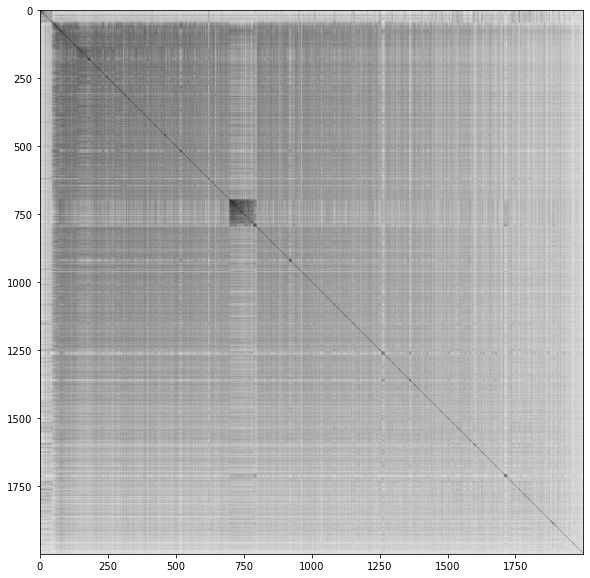

In [8]:
from pyclustertend import vat

#1000 and 5000 samples give very similar vat graph.
#adjustable: len count adjustable, but when it is greater than 3000, it will take time to draw a vat
if len(vlines) > 2000:
    samples = vlines[np.random.choice(vlines.shape[0], 2000, replace=False), :]
    vat(samples) #take data matrix, not dist matrix
else:
    vat(vlines)


## BIRCH clustering: upper level raw clustering 
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html

In [9]:
#adjustable: all three parameters are adjustable. 
#branching_factor: greater gives more natural cluatering results
#n_clusters: total clusters to output. If set to None, subclusters will be returned directly (and not merged into clusters)
#threshold: Euclidean distance threshold for merging subclusters. Sensitive. Set n_clusters to None and experiment with 0.5, 0.55, etc. to observe the number of subclusters generated.

brc = Birch(branching_factor=200, n_clusters=6, threshold=0.8) #n_clusters = None, meaning unlimited  
%time brc.fit(vlines) 

brc.subcluster_labels_






Wall time: 3.86 s


Birch(branching_factor=200, n_clusters=6, threshold=0.8)

array([0, 3, 0, 3, 4, 3, 4, 4, 3, 1, 0, 3, 0, 3, 3, 3, 0, 4, 4, 4, 3, 3,
       4, 3, 3, 4, 4, 0, 4, 3, 4, 4, 0, 0, 0, 1, 1, 0, 0, 0, 3, 0, 0, 1,
       0, 1, 0, 5, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 0, 0, 4, 2,
       3, 3, 0, 0, 3, 3, 0, 4, 0, 1, 0, 4, 3, 0, 2, 0, 3, 3, 3, 3, 1, 2,
       0, 2, 2, 3, 3, 2, 1, 1, 1, 5, 5, 3, 5, 3, 3, 1, 4, 5, 2, 1, 5, 2,
       5, 2, 1, 1, 0, 3, 1, 3, 4, 1, 0, 0, 4, 1, 4, 0, 1, 4, 5, 3, 1, 0,
       1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 2, 0, 2, 2, 2, 4, 4, 2, 2,
       5, 1, 0, 2, 5, 2, 0, 2, 2, 2, 2, 1, 3, 0, 2, 2, 2, 2, 5, 2, 3, 5,
       5, 2, 5, 2, 2, 2, 2, 3, 2, 0, 4, 2, 0, 0, 4, 3, 2, 0, 0, 2, 0, 0,
       2, 0, 4, 0, 2, 1, 0, 0, 5, 2, 2, 1, 3, 0, 4, 4, 4, 3, 0, 5, 0, 0,
       5, 0, 3, 0, 0, 2, 1, 0, 4, 0, 0, 1, 0, 0, 1, 1, 0, 0, 2, 2, 1, 0,
       0, 1, 4, 0, 1, 1, 4, 0, 0, 4, 0, 1, 0, 1, 2, 0, 0, 0, 0, 1, 0, 2,
       1, 0, 4, 4, 4, 0, 4, 4, 3, 3, 1, 1, 0, 3, 0, 3, 1, 3, 2, 1, 1, 0,
       4, 4, 4, 4, 2, 2, 1, 0, 1, 1, 0, 3, 3, 0, 3,

In [10]:
labels = brc.predict(vlines)
df = pd.DataFrame({'src':df_content['src'], 'birchcluster':labels, 'content':plines, 'original':df_content['original']}) 
df 
tab = df.groupby(['src', 'birchcluster']).size()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(tab.unstack().transpose())
    


,src,birchcluster,content,original
0,SESAR,0,soil bulk density texture,Soil bulk density and texture sample
1,SESAR,0,johnston draw elevation aspect under-plant,Johnston Draw 1650 m Elevation S Aspect Sample...
2,SESAR,0,soil,"Soil samples, 0-10 cm"
3,SESAR,3,vegetation litter non-woody,Vegetation litter samples non-woody
4,SESAR,3,cuttings,Cuttings
...,...,...,...,...
71972,SESAR,4,coarsening janus,1 COARSENING; Janus sample_id: 402282
71973,SESAR,4,coarser janus,2 COARSER; Janus sample_id: 402283
71974,SESAR,4,finer janus,4 FINER; Janus sample_id: 402285
71975,SESAR,4,fining janus,3 FINING; Janus sample_id: 402284


src           SESAR
birchcluster       
0             12017
1              1103
2               282
3             49049
4              9331
5               195


In [11]:
#Gethering terms using TFIDF 

def gatherTerm(cframe, threshold):
    #adjustable: max_df: [0-1] maximal precentage of the documents containing the word, Set to 1 would make all words eligible, 0, no words eligible .
    #min_df: [0-1] minimal precentage of the documents containing the word, Set to 1 would make essentially no words eligible, 0, all words are eligible.
    #max_features: max number of eligible words will be selected to make the tfidf matrix
    #more settings see https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

    tfidf_vectorizer = TfidfVectorizer(max_df = 0.8, max_features=500, min_df=0.1, stop_words='english',
                                  use_idf=True)
    try:
        tfidf_matrix = tfidf_vectorizer.fit_transform(cframe['description'])
        terms = tfidf_vectorizer.get_feature_names()
        ordered_index = tfidf_matrix.toarray().argsort()[:, ::-1]
        allterms = []
        for i in range(0, len(cframe)):
            n_terms = []
            for ind in ordered_index[i,]: 
                if tfidf_matrix[i, ind] > threshold:
                    n_terms.append(terms[ind]) 
            allterms.append(n_terms)
        return allterms
        
    except ValueError:#no term obtained from tfidf when all records holds the same set of terms
        return []

In [12]:
#produce terms from Birch clustering result

frame = df[['birchcluster','content']]
frame = frame.rename(columns={'birchcluster':'cluster', 'content':'description'})
cframe =frame.groupby('cluster', as_index = False).agg({'description': ' '.join})
#adjustable: threshold > 0
terms = gatherTerm(cframe, threshold=0.1)
i=0
for term in terms:
    print('cluster '+ str(cframe.iloc[i]['cluster'])+':')
    print(term)
    i = i+1
    print()




cluster 0:
['pillow', 'flow', 'glass', 'large', 'lava', 'piece', 'surface', 'mag', 'type', 'fresh', 'barrel', 'dredge', 'sections', 'glassy', 'like', 'broken', 'sheet']

cluster 1:
['hfs', 'basanite', 'cpx', 'species', 'sci', 'yellow', 'granite', 'common', 'alteration', 'ol', 'vesicles']

cluster 2:
['round', 'shattered', 'barrel', 'tobifera', 'hill', 'garnet', 'valley', 'indurated', 'brownish', 'pyrite', 'fractured', 'quality', 'organic', 'trace', 'dropstone', 'beach', 'loose', 'ridge', 'glacier', 'sand']

cluster 3:
['medium', 'mineral', 'light', 'flow', 'number', 'quality', 'group', 'size', 'plagioclase', 'variety', 'feldspar', 'crystal', 'lava', 'phenocrysts', 'biotite', 'granite', 'angular', 'vesicular', 'fragments', 'display', 'tuff', 'volcanic', 'mud', 'contact', 'dike']

cluster 4:
['clay', 'piece', 'interval', 'vein', 'sand', 'ash', 'xrf', 'silt', 'mud', 'sed', 'light', 'nodule', 'rich', 'ooze', 'glass', 'clast', 'sandy', 'trace']

cluster 5:
['clast', 'supported', 'types', 'l

## clustering of subclusters of BIRCH result with parallal programming
https://www.machinelearningplus.com/python/parallel-processing-python/# not working!

https://github.com/yngvem/parallelising-python 

also see https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

https://github.com/mdimura/sparsehc-dm

https://pypi.org/project/fastcluster/

https://joblib.readthedocs.io/en/latest/generated/joblib.Parallel.html


In [13]:
from fastcluster import linkage_vector
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram


#birchcluster_df: the input observation data (D=300xN)
#birchcluster_number:  cluster number of birchcluster_df in BIRCH result 
#min_obs: minimal observations in birchcluster_df to run hierarichal clustering, must be >=2

def h_clustering_fast(birchcluster_df, birchcluster_number, link_method, min_obs=2 ):
    print(birchcluster_number)
    if len(birchcluster_df) < min_obs:
        return [] 
    else:
        linkage_matrix = fastcluster.linkage_vector(birchcluster_df, link_method) #single, complete, average, weighted, median, centroid, ward
        return linkage_matrix
    
#result = h_clustering_fast(vlines[df.index[df['birchcluster']==0]], 0, 'ward', 20)
#result
    

In [14]:
#birchcluster_df: df holding the birchcluster observation content
#birchcluster_number:  cluster number of birchcluster_df in BIRCH result 
#linkage_matrix: the linkage_matrix for the birchcluster
#t: threshold to obtain clusters from hierarchical clustering for the specified criterion
#criterion: criterion used to obtain clusters

def obtain_h_clusters(birchcluster_df, birchcluster_number, linkage_matrix, t=10, criterion="maxclust"):
    if np.any(linkage_matrix):
        clusters = fcluster(linkage_matrix, t, criterion=criterion) #distance, inconsistency
        num_clusters = len(np.unique(clusters))
        birchcluster_df = birchcluster_df.reset_index()
        cresult = birchcluster_df[['index']]
        cresult['hcluster']= clusters
        records = {'description':df[df['birchcluster']==birchcluster_number].content, 'cluster':clusters, 'birchcluster':birchcluster_number}
        frame = pd.DataFrame(records, columns=['description', 'cluster', 'birchcluster'])
        cframe =frame.groupby('cluster', as_index = True).agg({'description': ' '.join})
        return cresult
    else:
        return []
    
#TODO: can't use distance criterion, test other criterion options
    
#len(results)
#16 empty
#cresult = obtain_h_clusters(df[df['birchcluster']==3], 3, linkage_matrix=results[3], t=3 if df[df['birchcluster']==3].shape[0] < 100 else 10 , criterion="maxclust")
#cresult
    
       
            


In [15]:
results = []   
#adjustable: linkmethod: single, complete, average, weighted, median, centroid, ward. Not recommend 'single' for samples dataset.
#min_obs >= 2, minimal number of observations in a cluster to form further clusters
%time results = Parallel(n_jobs=8, verbose=1)(delayed(h_clustering_fast)(vlines[df.index[df['birchcluster']==c]], c, 'ward', 2)  for c in range(0, len(df.birchcluster.unique())))
print("# of linkage matrices obtained: "+str(len(results)))


cresultlist = []
#adjustable: t, number of final/leaf clusters from hierarchical clustering
for cresult in Parallel(n_jobs=8,verbose=1)(delayed(obtain_h_clusters)(df[df['birchcluster']==c], c, linkage_matrix=results[c], t=3 if df[df['birchcluster']==c].shape[0] < 100 else 10, criterion='maxclust') for c in range(0, len(df.birchcluster.unique()))):
    cresultlist.append(cresult)

combined = pd.DataFrame()
#concat list of cresult row-wise
for cresult in cresultlist:
    print("cresult:")
    print(cresult)
    combined = pd.concat([combined, cresult], ignore_index=True)

  
combined.set_index('index', inplace=True)
df = df.join(combined) #this is the output df
print(df)



        



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of   6 | elapsed: 15.4min finished


Wall time: 15min 25s
# of linkage matrices obtained: 6


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


cresult:
       index  hcluster
0          0         2
1          1         2
2          2         3
3          5         3
4          7        10
...      ...       ...
12012  71930         8
12013  71932         7
12014  71944         3
12015  71945         5
12016  71947         8

[12017 rows x 2 columns]
cresult:
      index  hcluster
0        24         8
1        25         8
2        55         8
3       694         4
4      1294         4
...     ...       ...
1098  71009         8
1099  71013         6
1100  71104         1
1101  71923         1
1102  71938         2

[1103 rows x 2 columns]
cresult:
     index  hcluster
0     2188         6
1     2205         6
2     3256         9
3     3307         9
4     3310        10
..     ...       ...
277  47599         4
278  47605         9
279  47623         9
280  64627         6
281  65811         9

[282 rows x 2 columns]
cresult:
       index  hcluster
0          3         2
1          4         2
2          8         8
3    

[Parallel(n_jobs=8)]: Done   6 out of   6 | elapsed:    2.0s finished


In [16]:
#produce terms from Birch + hierarchical clustering results

df["cluster"] = df["birchcluster"].astype(str) +'-'+ df["hcluster"].astype(str)
frame = df[['cluster','content']]
frame = frame.rename(columns={'content':'description'})
cframe =frame.groupby('cluster', as_index = False).agg({'description': ' '.join})
terms = gatherTerm(cframe, 0.1)
i=0
allterms = list()
for term in terms:
    print('cluster '+cframe.iloc[i]['cluster']+':')
    print(term)
    i = i+1
    print()
    allterms.extend(term)

from collections import Counter
counter = Counter(allterms)
counter.most_common()
       


cluster 0-1:
['pillow', 'glass', 'glassy', 'sheet', 'fresh', 'piece', 'flow', 'lava', 'pillows', 'rind']

cluster 0-10:
['core', 'liner', 'barrel', 'floor', 'section', 'cut', 'split', 'disturbed']

cluster 0-2:
['rock', 'unit', 'small', 'flow', 'large', 'layer', 'lava', 'surface', 'dark', 'cone', 'like', 'base', 'massive', 'size', 'pillow', 'chimney', 'inclusions', 'near', 'light']

cluster 0-3:
['mag', 'bag', 'stop', 'start', 'type', 'vial', 'gas', 'core', 'sediment', 'location', 'small', 'float', 'bags', 'water', 'dredge', 'hand', 'number', 'vent', 'flow']

cluster 0-4:
['round', 'janus', 'half']

cluster 0-5:
['paleo', 'trace', 'janus', 'lab']

cluster 0-6:
['void', 'gas', 'core', 'db', 'section']

cluster 0-7:
['core', 'disturbed', 'recovery', 'collected', 'inclusion', 'section', 'altered', 'orientation', 'janus', 'db', 'location', 'like', 'taken', 'flow', 'interval', 'added', 'material', 'description', 'hole']

cluster 0-8:
['section', 'janus']

cluster 0-9:
['liner', 'split', 'se

[('janus', 17),
 ('db', 10),
 ('core', 8),
 ('section', 8),
 ('gray', 8),
 ('black', 7),
 ('grained', 7),
 ('fine', 7),
 ('disturbed', 6),
 ('void', 6),
 ('sec', 6),
 ('basalt', 6),
 ('sandstone', 6),
 ('flow', 5),
 ('dark', 5),
 ('location', 5),
 ('green', 5),
 ('granite', 5),
 ('white', 5),
 ('medium', 5),
 ('split', 4),
 ('rock', 4),
 ('water', 4),
 ('paleo', 4),
 ('altered', 4),
 ('added', 4),
 ('red', 4),
 ('brown', 4),
 ('coarse', 4),
 ('conglomerate', 4),
 ('pillow', 3),
 ('lava', 3),
 ('liner', 3),
 ('unit', 3),
 ('small', 3),
 ('layer', 3),
 ('bag', 3),
 ('gas', 3),
 ('recovery', 3),
 ('taken', 3),
 ('cpx', 3),
 ('orange', 3),
 ('good', 3),
 ('group', 3),
 ('shale', 3),
 ('slab', 3),
 ('sand', 3),
 ('quartz', 3),
 ('biotite', 3),
 ('vesicular', 3),
 ('glass', 2),
 ('barrel', 2),
 ('like', 2),
 ('base', 2),
 ('massive', 2),
 ('size', 2),
 ('chimney', 2),
 ('light', 2),
 ('stop', 2),
 ('start', 2),
 ('sediment', 2),
 ('bags', 2),
 ('hand', 2),
 ('number', 2),
 ('round', 2),
 ('h

In [17]:
#see corresponding content

df[(df['birchcluster']==5) & (df['hcluster']==8)]

,src,birchcluster,content,original,hcluster,cluster
3017,SESAR,5,ashflow block,ashflow block,8,5-8
6693,SESAR,5,pp(lad voids,PP(LAD) 140-150 CM (DB) VOIDS THROUGH OUT;,8,5-8
6694,SESAR,5,pp(lad,PP(LAD) 140-150 CM;,8,5-8
7095,SESAR,5,tsb\pal,IW 13-16 TSB\PAL;,8,5-8
7226,SESAR,5,pa;leo,3 CM TO PA;LEO.;,8,5-8
7772,SESAR,5,exhaust_code,EXHAUST_CODE : x,8,5-8
9381,SESAR,5,porties,Porties,8,5-8
9805,SESAR,5,heatflow run core,HEATFLOW RUN BETWEEN CORE 10H AND 11;,8,5-8
10147,SESAR,5,ashflow,ashflow,8,5-8
11545,SESAR,5,siltst,siltst.,8,5-8
